In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC, SVC
from skimage.feature import hog
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import deque
from sklearn.preprocessing import StandardScaler

import glob
%matplotlib inline

loading set of images

In [2]:
cars = glob.glob('../vehicles/**/*.png', recursive=True) 
notcars = glob.glob('../non-vehicles/**/*.png', recursive=True) 

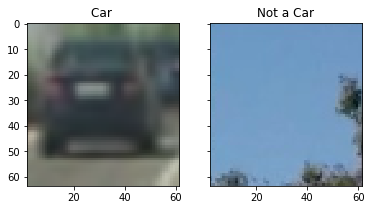

In [3]:
example_car_img = mpimg.imread(cars[0])
example_no_car_img = mpimg.imread(notcars[0])

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (6,3))
ax1.imshow(example_car_img)
ax1.set_title('Car ')
ax2.imshow(example_no_car_img)
ax2.set_title('Not a Car')

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

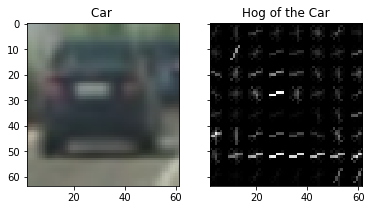

In [5]:
example_gray = cv2.cvtColor(example_car_img, cv2.COLOR_BGR2GRAY)

# Define HOG parameters
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
orientations = 9  # HOG orientations
pixels_per_cell = 8 # HOG pixels per cell
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
cells_per_block = 2 # HOG cells per block


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(example_gray, orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (6,3))
ax1.imshow(example_car_img, cmap='gray')
ax1.set_title('Car ')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Hog of the Car')

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
import time

# Reduce the sample size because HOG features are slow to compute
sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


8.23 Seconds to extract HOG features...


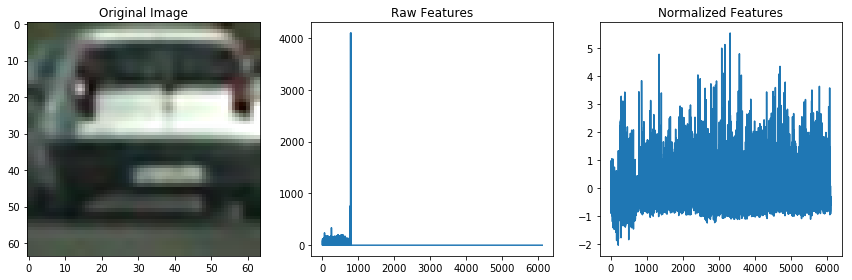

In [8]:



if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [9]:
from sklearn.model_selection import train_test_split

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [10]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.2,
                                                    random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', 
      cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [11]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

0.38 Seconds to train SVC...


In [12]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  1.0


In [13]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  0.  0.  1.]
0.00244 Seconds to predict 10 labels with SVC


In [ ]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [ ]:
box_image = mpimg.imread('./test_images/test1.jpg')

windows = slide_window(box_image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(box_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img = draw_boxes(box_image, windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [ ]:
class CarTrackingPipeline():
    def __init__(self, sample_image, classifier=None, is_video=False):
        self.sample_image = sample_image
        self.is_video = is_video
        self.clf = classifier
        self.counter = 3
        self.current_heatmap = np.zeros_like(sample_image[:,:,0]).astype(np.float32)
        self.outputs = []
        self.heatmaps = []
        self.labels = []
        
    def get_windowed_features(self, img, scale=1, spatial_size=(32,32), cells_per_step=1, pixels_per_cell=8, 
                              nbins=32, bins_range=(0, 1), color_space='HSV'):
        
        image_window_size = 64
        
        image = img.astype(np.float32) / np.max(img)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        image = cv2.resize(image, (np.int(image.shape[1] // scale), np.int(image.shape[0] // scale)))
        x_block_count = (image.shape[1] // pixels_per_cell) - 1
        y_block_count = (image.shape[0] // pixels_per_cell) - 1
        features_per_block = orientations * cells_per_block**2
        blocks_per_window = (image_window_size // pixels_per_cell) -1
        cells_per_step = 1
        x_step_count = (x_block_count - blocks_per_window) // cells_per_step
        y_step_count = (y_block_count - blocks_per_window) // cells_per_step
        
        ch0 = image[:,:,0]
        ch1 = image[:,:,1]
        ch2 = image[:,:,2]

        
        hog0 = get_hog_features(ch0, orientations, pixels_per_cell, cells_per_block, feature_vec=False)
        hog1 = get_hog_features(ch1, orientations, pixels_per_cell, cells_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orientations, pixels_per_cell, cells_per_block, feature_vec=False)

        features_for_window = []
        windows = []
        for x_step in range(x_step_count):
            for y_step in range(y_step_count):
                x_pos = x_step * cells_per_step
                y_pos = y_step * cells_per_step
                
                features = []

                xleft = x_pos*pixels_per_cell
                ytop = y_pos*pixels_per_cell
                
                image_tile = cv2.resize(image[ytop:ytop+image_window_size, xleft:xleft+image_window_size], (64,64))
                
                image_tile = image[y_pos*pixels_per_cell:y_pos*pixels_per_cell+image_window_size,
                                    x_pos*pixels_per_cell:x_pos*pixels_per_cell+image_window_size]
                
                features.append(cv2.resize(image_tile, spatial_size).ravel())

                features.append(np.histogram(image_tile[:,:,0], bins=nbins, range=bins_range)[0])
                features.append(np.histogram(image_tile[:,:,1], bins=nbins, range=bins_range)[0])
                features.append(np.histogram(image_tile[:,:,2], bins=nbins, range=bins_range)[0])

                hog_feat0 = hog0[y_pos:y_pos+blocks_per_window,x_pos:x_pos+blocks_per_window].ravel()
                hog_feat1 = hog1[y_pos:y_pos+blocks_per_window,x_pos:x_pos+blocks_per_window].ravel()
                hog_feat2 = hog2[y_pos:y_pos+blocks_per_window,x_pos:x_pos+blocks_per_window].ravel()
                hog_features = np.concatenate((hog_feat0, hog_feat1, hog_feat2))
                
                features.append(hog_features)
                w_loc0 =(int(xleft * scale), 
                         int(ytop * scale))
                w_loc1 = (int((xleft+image_window_size) * scale), 
                          int((ytop+image_window_size) * scale))

                features_for_window.append(np.hstack(features))    
                windows.append((w_loc0, w_loc1))
                
        return features_for_window, windows
    
    def find_hit_windows(self, image=None, scale=1.5, y_start_stop=(0, 720), cells_per_step=1):
        adjust_y_0 = y_start_stop[0]
        adjust_y_1 = y_start_stop[1]
        adjust_x = 700
        image = image[adjust_y_0:adjust_y_1, adjust_x:]
        hits_windows = []
        features, windows = self.get_windowed_features(image, scale, cells_per_step=cells_per_step)
        for feature, window in zip(features, windows):
            f = X_scaler.transform(np.array(feature).reshape(1, -1))
            prediction = lclf.predict(f)
            if prediction == 1:
                coords = window
                coords_adjusted = ((coords[0][0] + adjust_x, coords[0][1] + adjust_y_0), 
                                    (coords[1][0] + adjust_x, coords[1][1] + adjust_y_0)) 
                hits_windows.append(coords_adjusted)
        return hits_windows
        
    def update_heatmap(self, boxlist):
        heatmap = np.zeros_like(self.sample_image[:,:,0]).astype(np.float32)    
        alpha = 0.1
        for box in boxlist:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        heatmap[heatmap < 5] = 0
        self.current_heatmap = alpha * heatmap + (1-alpha) * self.current_heatmap
        maxim = np.max(self.current_heatmap)
        self.current_heatmap[self.current_heatmap <= 1] = 0
        return self.current_heatmap

    def draw_boxes(self, image, bboxes, color=(255, 0, 255), thick=2):
        draw_img = np.copy(image)
        for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
        return draw_img 
    
    def draw_labeled_boxes(self, image, heatmap):
        # from provided Udacity utility functions
        labels = label(heatmap)
#         self.labels.append(labels[0])
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
        return image
    
    def process_frame(self, image):
        if self.is_video:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        boxes = self.find_hit_windows(image, scale=1.5, y_start_stop=(385, 550), cells_per_step=1) + \
                self.find_hit_windows(image, scale=2, y_start_stop=(500, 600), cells_per_step=2) 
        
        heatmap = tracker.update_heatmap(boxes)
#         self.heatmaps.append(heatmap)
        heatmap_image = self.draw_labeled_boxes(image, heatmap)
#         heatmap_image = self.draw_boxes(image, boxes)
        image = cv2.cvtColor(heatmap_image, cv2.COLOR_BGR2RGB)
#         self.outputs.append(image)
        return image


In [ ]:

tracker = CarTrackingPipeline(sample_image=box_image, classifier=svc)
plt.imshow(tracker.process_frame(box_image))